# 🎶 Music Generation - MuseGAN

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the Model](#build)
3. [Train the Model](#train)
4. [Generate images](#generate)

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, initializers, metrics

from music21 import stream, tempo, note, duration

from utils.music import notes_to_midi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [2]:
N_BARS = 2
N_STEPS_PER_BAR = 16
BATCH_SIZE = 64
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32
CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 6000
LOAD_MODEL = False

## 1. Prepare the Data

In [3]:
# Load the data
file = os.path.join("/app/data/bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [4]:
N_SONGS = len(data)
print(f"{N_SONGS} chorales in the dataset")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"{N_BEATS, N_TRACKS} shape of chorale 0")
print('\nChorale 0')
print(chorale[:8])

229 chorales in the dataset
(192, 4) shape of chorale 0

Chorale 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [5]:
two_bars = np.array([x[:(N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype = int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f'Two bars shape {two_bars.shape}')

Two bars shape (229, 2, 16, 4)


In [6]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
INPUT_DIM = data_binary.shape[1:]
print(f'Data binary shape {data_binary.shape}')

Data binary shape (229, 2, 16, 84, 4)


## 2. Build the GAN <a name="build"></a>

In [7]:
initializer = initializers.RandomNormal(mean=0., stddev=0.02)

def conv(x, f, k, s, p):
    x = layers.Conv3D(filters = f
                , kernel_size = k
                , padding = p
                , strides = s
                , kernel_initializer = initializer
                )(x)
    x = layers.LeakyReLU()(x)
    return x

In [8]:
critic_input = layers.Input(shape=INPUT_DIM, name='critic_input')

def Critic():
    x = critic_input

    x = conv(x, f=128, k = (2,1,1), s = (1,1,1), p = 'valid')
    x = conv(x, f=128, k = (N_BARS - 1,1,1), s = (1,1,1), p = 'valid')
    x = conv(x, f=128, k = (1,1,12), s = (1,1,12), p = 'same')
    x = conv(x, f=128, k = (1,1,7), s = (1,1,7), p = 'same')
    x = conv(x, f=128, k = (1,2,1), s = (1,2,1), p = 'same')
    x = conv(x, f=128, k = (1,2,1), s = (1,2,1), p = 'same')
    x = conv(x, f=256, k = (1,4,1), s = (1,2,1), p = 'same')
    x = conv(x, f=512, k = (1,3,1), s = (1,2,1), p = 'same')

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer = initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(1, activation=None, kernel_initializer = initializer)(x)

    return models.Model(critic_input, critic_output)

In [9]:
critic = Critic()
# critic.summary()

2022-11-07 16:18:10.618828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-07 16:18:10.618923: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-07 16:18:10.619006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d738adb06866): /proc/driver/nvidia/version does not exist
2022-11-07 16:18:10.620551: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
                filters = f
                , kernel_size = k
                , padding = p
                , strides = s
                , kernel_initializer = initializer
                )(x)
    if bn:
        x = layers.BatchNormalization(momentum = 0.9)(x)

    if a == 'lrelu':
        x = layers.LeakyReLU()(x)
    else:
        x = layers.Activation(a)(x)
    return x

def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name='temporal_input')
    x = layers.Reshape([1,1,Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2,1), s=(1,1), a= 'relu', p = 'valid', bn = True)
    x = conv_t(x, f=Z_DIM, k=(N_BARS - 1,1), s=(1,1), a= 'relu', p = 'valid', bn = True)
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)

# TemporalNetwork().summary()

In [11]:
def BarGenerator():

    input_layer = layers.Input(shape=(Z_DIM * 4,), name='bar_generator_input')

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum = 0.9)(x)
    x = layers.Activation('relu')(x)

    x = layers.Reshape([2,1,512])(x)
    x = conv_t(x, f=512, k=(2,1), s=(2,1), a= 'relu',  p = 'same', bn = True)
    x = conv_t(x, f=256, k=(2,1), s=(2,1), a= 'relu', p = 'same', bn = True)
    x = conv_t(x, f=256, k=(2,1), s=(2,1), a= 'relu', p = 'same', bn = True)
    x = conv_t(x, f=256, k=(1,7), s=(1,7), a= 'relu', p = 'same',bn = True)
    x = conv_t(x, f=1, k=(1,12), s=(1,12), a= 'tanh', p = 'same', bn = False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR , N_PITCHES ,1])(x)

    return models.Model(input_layer, output_layer)
# BarGenerator().summary()

In [12]:
def Generator():

    chords_input = layers.Input(shape=(Z_DIM,), name='chords_input')
    style_input = layers.Input(shape=(Z_DIM,), name='style_input')
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name='melody_input')
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name='groove_input')

    # CHORDS -> TEMPORAL NETWORK
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input) # [n_bars, z_dim]

    # MELODY -> TEMPORAL NETWORK
    melody_over_time = [None] * N_TRACKS # list of n_tracks [n_bars, z_dim] tensors
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x: x[:,track,:])(melody_input)
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # CREATE BAR GENERATOR FOR EACH TRACK
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # CREATE OUTPUT FOR EVERY TRACK AND BAR
    bars_output = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c = layers.Lambda(lambda x: x[:,bar,:], name = 'chords_input_bar_' + str(bar))(chords_over_time)  # [z_dim]
        s = style_input # [z_dim]

        for track in range(N_TRACKS):

            m = layers.Lambda(lambda x: x[:,bar,:])(melody_over_time[track]) # [z_dim]
            g = layers.Lambda(lambda x: x[:,track,:])(groove_input) # [z_dim]

            z_input = layers.Concatenate(axis = 1, name = 'total_input_bar_{}_track_{}'.format(bar, track))([c,s,m,g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis = -1)(track_output)

    generator_output = layers.Concatenate(axis = 1, name = 'concat_bars')(bars_output)

    return models.Model([chords_input, style_input, melody_input, groove_input], generator_output)


In [13]:
generator = Generator()
# generator.summary()

In [14]:
class MuseGAN(keras.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric,self.g_loss_metric]
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            style_random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            melody_random_latent_vectors = tf.random.normal(shape=(batch_size, N_TRACKS, self.latent_dim))
            groove_random_latent_vectors = tf.random.normal(shape=(batch_size, N_TRACKS, self.latent_dim))
            
            random_latent_vectors = [chords_random_latent_vectors
                                     , style_random_latent_vectors
                                     , melody_random_latent_vectors
                                     , groove_random_latent_vectors]

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training = True)
                fake_predictions = self.critic(fake_images, training = True)
                real_predictions = self.critic(real_images, training = True)
                
                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight
                
            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        chords_random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        style_random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        melody_random_latent_vectors = tf.random.normal(shape=(batch_size, N_TRACKS, self.latent_dim))
        groove_random_latent_vectors = tf.random.normal(shape=(batch_size, N_TRACKS, self.latent_dim))

        random_latent_vectors = [chords_random_latent_vectors
                                 , style_random_latent_vectors
                                 , melody_random_latent_vectors
                                 , groove_random_latent_vectors]
            
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}


In [15]:
# Create a MuseGAN

musegan = MuseGAN(
    critic=critic
    , generator=generator
    , latent_dim=Z_DIM
    , critic_steps = CRITIC_STEPS
    , gp_weight = GP_WEIGHT
)

In [48]:
if LOAD_MODEL:
    musegan.load_weights('./checkpoint/checkpoint.ckpt')

## 3. Train the MuseGAN <a name="train"></a>

In [49]:
# Compile the GAN
musegan.compile(
    c_optimizer=optimizers.Adam(learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [60]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        chords_random_latent_vectors = tf.random.normal(shape=(self.num_scores, Z_DIM))
        style_random_latent_vectors = tf.random.normal(shape=(self.num_scores, Z_DIM))
        melody_random_latent_vectors = tf.random.normal(shape=(self.num_scores, N_TRACKS, Z_DIM))
        groove_random_latent_vectors = tf.random.normal(shape=(self.num_scores, N_TRACKS, Z_DIM))
        random_latent_vectors = [chords_random_latent_vectors
                                     , style_random_latent_vectors
                                     , melody_random_latent_vectors
                                     , groove_random_latent_vectors]
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images.numpy()
        notes_to_midi(generated_images, filename = "output_" + str(epoch), N_BARS, N_TRACKS, N_STEPS_PER_BAR)
        # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)
        
music_generator_callback = MusicGenerator(5)

In [61]:
history = musegan.fit(
    data_binary, 
    epochs=EPOCHS, 
    # steps_per_epoch = 10, 
    # initial_epoch = 39,
    callbacks=[model_checkpoint_callback, tensorboard_callback, music_generator_callback],
)

Epoch 1/6000
8/8 [==============================] - 41s 5s/step - c_loss: -63.5193 - c_wass_loss: -93.8320 - c_gp: 3.0313 - g_loss: -626.1360
Epoch 2/6000
8/8 [==============================] - 48s 6s/step - c_loss: -65.6169 - c_wass_loss: -101.7527 - c_gp: 3.6136 - g_loss: -528.5191
Epoch 3/6000
8/8 [==============================] - 42s 5s/step - c_loss: -71.6144 - c_wass_loss: -103.8253 - c_gp: 3.2211 - g_loss: -412.7334
Epoch 4/6000
8/8 [==============================] - 56s 7s/step - c_loss: -71.1177 - c_wass_loss: -113.8311 - c_gp: 4.2713 - g_loss: -312.3600
Epoch 5/6000
8/8 [==============================] - 35s 4s/step - c_loss: -89.0641 - c_wass_loss: -142.8193 - c_gp: 5.3755 - g_loss: -605.8616
Epoch 6/6000
8/8 [==============================] - 38s 5s/step - c_loss: -84.6807 - c_wass_loss: -136.2341 - c_gp: 5.1553 - g_loss: -524.4396
Epoch 7/6000
8/8 [==============================] - 40s 5s/step - c_loss: -75.4326 - c_wass_loss: -125.8543 - c_gp: 5.0422 - g_loss: -444.9931


KeyboardInterrupt: 

In [ ]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

## Generate images

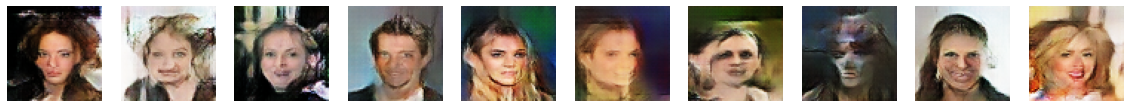

In [21]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgan.generator.predict(z_sample)
display(imgs, cmap = None)